# Combining deconvolved IRDIS and ZIMPOL images

lots of ways to do it

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
import numpy.ma as ma

#Images of the mean_combined data
from skimage.transform import rescale, resize, downscale_local_mean




In [2]:
def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")
        
def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def Loadimage_IRDIS(star,fittype,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/deconvolution/deconvolved_'+fittype+'/'
    ifile = '*.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            if fittype=='Q_phi': image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    return image

def Loadimage_IRDIS(star,fittype,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    print("second version")
    dir =dirdat + 'Deconvolution_corr_tel+unres/IRDIS/deconvolved_'+fittype+'/'
    ifile = '*H_decon.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            if fittype=='Q_phi': image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    return image

def Loadpsf(star,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/reduced_pdi/no_star_pol_subtr/'  
    if star=='u_mon_combined':
        dir =dirdat + star + '/reduced_pdi/no_star_pol_subtr/' #for combined set
    psfile = '*I_tot.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSF = hdulPSF['Primary'].data
            
    return PSF

def Loadpsf(star,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    print(dirdat)
    dir =dirdat + 'IRDAP_Reduced/reduced_pdi/no_star_pol_subtr/'
    if star=='u_mon_combined':
        dir =dirdat + 'IRDAP_Reduced/reduced_pdi/no_star_pol_subtr/' #for combined set
    psfile = '*I_tot.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSF = hdulPSF['Primary'].data

    return PSF

def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data


    return fit

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)

# Set up

In [17]:

stars=["HR4049_combined",'V709_Car','HR4226','01.SCI_UMon','01.SCI_AR_Pup']
irdis_stars=['01.SCI_UMon','01.SCI_AR_Pup']
irdis_to_zimp={'01.SCI_UMon':'01.SCI_UMon','01.SCI_AR_Pup':'01.SCI_AR_Pup'}
zimp_to_irdis={'01.SCI_AR_Pup':'none','HR4049_20190108':'hr4049','HR4049_20190107':'hr4049',"HR4049_combined":'hr4049','V709_Car':'none','HR4226':'none','01.SCI_UMon':'u_mon_combined'}

starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':' AR Pup'}

star=stars[-2]

camera = 'ZIMPOL/'

ps=3.6
# ps = 12.27
lim=50

dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel+unres/'+camera
# dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/u_mon_combined/deconvolution/'

figfolder=dirdat + 'deconvolved_'
figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera
savefig_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDIS+ZIMPOL/'
createfolder(savefig_folder)
dirdat_IRDIS = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/' #data coming from


In [18]:
zimp_to_irdis[star]

'u_mon_combined'

In [19]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Deconvolution_corr_tel+unres/ZIMPOL/deconvolved_'

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/


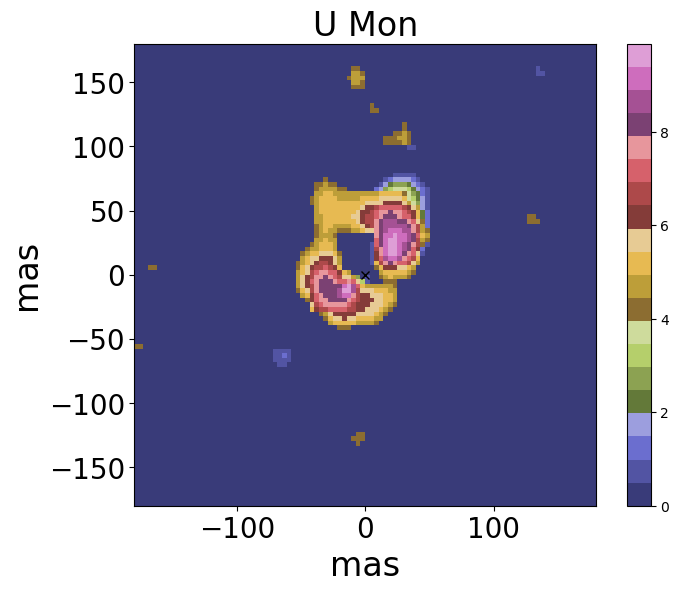

In [60]:
import matplotlib as mpl

if zimp_to_irdis[star]!='none':
    q_phi_V=Loadimage(figfolder+'Q_phi/',star+'_'+'V'+'_decon.fits')                       # write output
    q_phi_I=Loadimage(figfolder+'Q_phi/',star+'_'+'I'+'_decon.fits')                       # write output
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output


    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output

    pi_H=Loadimage_IRDIS(zimp_to_irdis[star],'PI',dirdat_IRDIS)
    q_phi_H=Loadimage_IRDIS(zimp_to_irdis[star],'Q_phi',dirdat_IRDIS)
    i_H=Loadpsf(zimp_to_irdis[star],dirdat_IRDIS)


    q_phi_H_resc=rescale(q_phi_H, 12.27/ps,anti_aliasing=True)
    pi_H_resc=rescale(pi_H, 12.27/ps,anti_aliasing=True)

    adc=int(q_phi_H_resc.shape[0]/2-q_phi_I.shape[0]/2)
    bdc=int(q_phi_H_resc.shape[0]/2+q_phi_I.shape[0]/2)
    q_phi_H_resc=q_phi_H_resc[adc:bdc,adc:bdc]
    pi_H_resc=pi_H_resc[adc:bdc,adc:bdc]

    i_H=rescale(i_H, 12.27/ps,anti_aliasing=True)
    adc=int(i_H.shape[0]/2-512)
    bdc=int(i_H.shape[0]/2+512)
    i_H=i_H[adc:bdc,adc:bdc]

    if zimp_to_irdis[star]=='hr4049':
        cosi_V=np.cos(np.deg2rad(25))
        cosi_I=np.cos(np.deg2rad(26))
        cosi_H=np.cos(np.deg2rad(17))
    if zimp_to_irdis[star]=='u_mon_combined':
        cosi_V=np.cos(np.deg2rad(48))
        cosi_I=np.cos(np.deg2rad(40))
        cosi_H=np.cos(np.deg2rad(25))

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)
    R=np.sqrt(Xr**2 + (Yr)**2)
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
    R_deproj_H=np.sqrt(Xr**2 + (Yr/cosi_H)**2)


    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    i_sum_H=np.sum(i_H[mask])

    q_phi_H_resc[q_phi_H_resc<2]=0
    q_phi_H_resc_norm=q_phi_H_resc/i_sum_H*R_deproj_H*R_deproj_H#*(q_phi_H_resc>=1) ##q_phi_H_resc
    #print(np.max(q_phi_H_resc_norm))
    q_phi_V_norm=q_phi_V/i_sum_V*R_deproj_V*R_deproj_V#*(q_phi_V>=1)
    q_phi_I_norm=q_phi_I/i_sum_I*R_deproj_I*R_deproj_I#*(q_phi_I>=1)


    array=np.array([q_phi_H_resc_norm, q_phi_V_norm,q_phi_I_norm])
    #print(array.shape)

    q_phi_combine=np.sum(array,axis=0)


    fig, ax = plt.subplots(figsize=(8,6))
    #image=q_phi_combine

    #image=np.log10(q_phi_combine+1)
    image=np.arcsinh(q_phi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='tab20b'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max,extent=extent,cmap=cmap)
    plt.plot(0,0,'x', color='black')
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    #plt.title('All Q_PHI') 
    plt.savefig(savefig_folder+star+'_all_q_phi_discret.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    


In [21]:
 figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Deconvolution_corr_tel+unres/ZIMPOL/deconvolved_'

In [22]:
def Loadimage_IRDIS(star,fittype,dirdat):

    dir =dirdat + 'Deconvolution_corr_tel+unres/IRDIS/deconvolved_'+fittype+'/'
    ifile = '*H_decon.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            if fittype=='Q_phi': image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    return image

In [23]:
dirdat_IRDIS

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/'

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/
166304.61 210997.84 39218.52


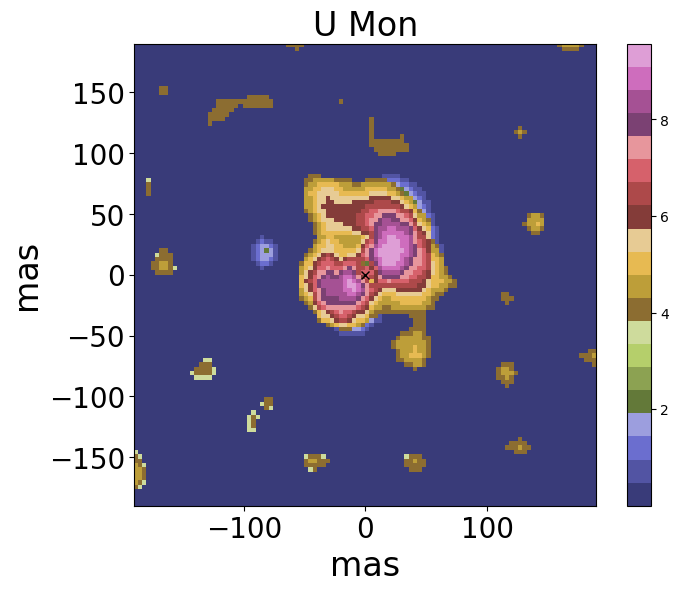

In [65]:
import matplotlib as mpl

if zimp_to_irdis[star]!='none':
    #pi_H_resc=[]
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output


    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output

    pi_H=Loadimage_IRDIS(zimp_to_irdis[star],'PI',dirdat_IRDIS)
    i_H=Loadpsf(zimp_to_irdis[star],dirdat_IRDIS)

   
    pi_H_resc=rescale(pi_H, 12.27/ps,anti_aliasing=True,preserve_range=True)

    adc=int(pi_H_resc.shape[0]/2-pi_I.shape[0]/2)
    bdc=int(pi_H_resc.shape[0]/2+pi_I.shape[0]/2)
    pi_H_resc=pi_H_resc[adc:bdc,adc:bdc]
    
    i_H=rescale(i_H, 12.27/ps,anti_aliasing=True,preserve_range=True)
    adc=int(i_H.shape[0]/2-512)
    bdc=int(i_H.shape[0]/2+512)
    i_H=i_H[adc:bdc,adc:bdc]

    if zimp_to_irdis[star]=='hr4049':
        cosi_V=np.cos(np.deg2rad(25))
        cosi_I=np.cos(np.deg2rad(26))
        cosi_H=np.cos(np.deg2rad(17))
    if zimp_to_irdis[star]=='u_mon_combined':
        cosi_V=np.cos(np.deg2rad(48))
        cosi_I=np.cos(np.deg2rad(40))
        cosi_H=np.cos(np.deg2rad(25))

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)            
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
    R_deproj_H=np.sqrt(Xr**2 + (Yr/cosi_H)**2)

    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    i_sum_H=np.sum(i_H[mask])
    print(i_sum_V,i_sum_I,i_sum_H)
    
    if star=='01.SCI_UMon':
        pi_H_resc[pi_H_resc<1.6]=0
    else:
        pi_H_resc[pi_H_resc<0.5]=0
    
    pi_H_resc_norm=pi_H_resc/i_sum_H*R_deproj_H*R_deproj_H#*()
    #print(np.max(pi_H_resc_norm))
    pi_V_norm=pi_V/i_sum_V*R_deproj_V*R_deproj_V#*(pi_V>=1)
    pi_I_norm=pi_I/i_sum_I*R_deproj_I*R_deproj_I#*(pi_I>=1)


    array=np.array([pi_H_resc_norm, pi_V_norm,pi_I_norm])

    pi_combine=np.sum(array,axis=0)
    pi_combine_max=np.max(pi_combine[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])

    
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    X, Y = np.meshgrid(xr, yr)

    fig, ax = plt.subplots(figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='tab20b'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max, extent=extent,cmap=cmap)
    
    #levels = [pi_combine_max/100, pi_combine_max/2]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_combine, levels=levels, colors=['white', 'black'], extent=extent)
    #levels = [1.1]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_I, levels=levels, colors=['white'], extent=extent)
    #levels = [1]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_V, levels=levels, colors=['violet'], extent=extent)

    plt.plot(0,0,'x', color='black')
    plt.xlim(-lim * ps - 10, lim * ps + 10)
    plt.ylim(-lim * ps - 10, lim * ps + 10)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    #plt.title('All PI') 
    plt.savefig(savefig_folder+star+'_all_pi_discret.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [27]:
zimp_to_irdis[star]

'u_mon_combined'

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/
166304.61 210997.84 39218.52


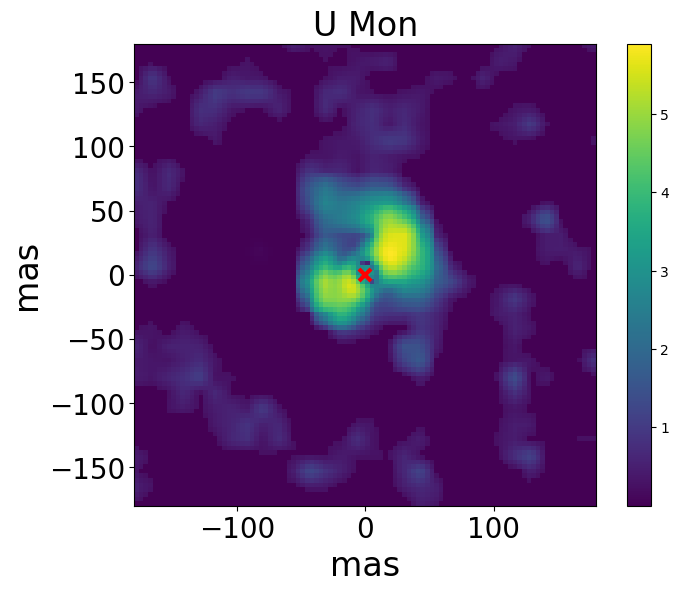

In [28]:
import matplotlib as mpl

if zimp_to_irdis[star]!='none':
    
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output


    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output

    pi_H=Loadimage_IRDIS(zimp_to_irdis[star],'PI',dirdat_IRDIS)
    i_H=Loadpsf(zimp_to_irdis[star],dirdat_IRDIS)


   
    pi_H_resc=rescale(pi_H, 12.27/ps,anti_aliasing=True,preserve_range=True)

    adc=int(pi_H_resc.shape[0]/2-pi_I.shape[0]/2)
    bdc=int(pi_H_resc.shape[0]/2+pi_I.shape[0]/2)
    pi_H_resc=pi_H_resc[adc:bdc,adc:bdc]
    
    i_H=rescale(i_H, 12.27/ps,anti_aliasing=True,preserve_range=True)
    adc=int(i_H.shape[0]/2-512)
    bdc=int(i_H.shape[0]/2+512)
    i_H=i_H[adc:bdc,adc:bdc]

    if zimp_to_irdis[star]=='hr4049':
        cosi_V=np.cos(np.deg2rad(25))
        cosi_I=np.cos(np.deg2rad(26))
        cosi_H=np.cos(np.deg2rad(17))
    if zimp_to_irdis[star]=='u_mon_combined':
        cosi_V=np.cos(np.deg2rad(48))
        cosi_I=np.cos(np.deg2rad(40))
        cosi_H=np.cos(np.deg2rad(25))

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)            
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
    R_deproj_H=np.sqrt(Xr**2 + (Yr/cosi_H)**2)

    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    i_sum_H=np.sum(i_H[mask])
    print(i_sum_V,i_sum_I,i_sum_H)
    
    pi_H_resc[pi_H_resc<0.5]=0

    pi_H_resc_norm=pi_H_resc/i_sum_H*20000
    #print(np.max(pi_H_resc_norm))
    pi_V_norm=pi_V/i_sum_V*20000
    pi_I_norm=pi_I/i_sum_I*20000


    array=np.array([pi_H_resc_norm, pi_V_norm,pi_I_norm])

    pi_combine=np.sum(array,axis=0)
    pi_combine_max=np.max(pi_combine[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])

    
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    X, Y = np.meshgrid(xr, yr)

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='viridis'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max, extent=extent,cmap=cmap)
    
    plt.plot(0,0,'x', color='red', markersize=8, mew=3)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    #plt.title('All PI') 
    plt.savefig(savefig_folder+star+'_sum_pi.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [29]:

import matplotlib as mpl

if zimp_to_irdis[star]=='none':
    
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output
    q_phi_V=Loadimage(figfolder+'Q_phi/',star+'_'+'V'+'_decon.fits')                       # write output
    q_phi_I=Loadimage(figfolder+'Q_phi/',star+'_'+'I'+'_decon.fits')                       # write output
    

    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output

    
   
    

    if star=='V709_Car':
        cosi_V=np.cos(np.deg2rad(27))
        cosi_I=np.cos(np.deg2rad(28))
        
    if star=='HR4226':
        cosi_V=np.cos(np.deg2rad(50))
        cosi_I=np.cos(np.deg2rad(40))
    if star=='AR_Pup_dc_notnorm':
        cosi_V=np.cos(np.deg2rad(80))
        cosi_I=np.cos(np.deg2rad(80))
 

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)
      
    R=np.sqrt(Xr**2 + (Yr)**2)
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
   

    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    
    pi_V[pi_V<1]=0
    pi_I[pi_I<1]=0
     #print(np.max(pi_H_resc_norm))
    pi_V_norm=pi_V/i_sum_V*R_deproj_V*R_deproj_V*10#*(pi_V>=1)
    pi_I_norm=pi_I/i_sum_I*R_deproj_I*R_deproj_I*10#*(pi_I>=1)


    array=np.array([pi_V_norm,pi_I_norm])
    #print(array.shape)

    pi_combine=np.sum(array,axis=0)


    fig, ax = plt.subplots(figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine+1)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='tab20b'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max,extent=extent,cmap=cmap)
    plt.plot(0,0,'x', color='black')
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    plt.savefig(savefig_folder+star+'_all_pi_discret.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [30]:
import matplotlib as mpl

if zimp_to_irdis[star]=='none':
    
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output
    q_phi_V=Loadimage(figfolder+'Q_phi/',star+'_'+'V'+'_decon.fits')                       # write output
    q_phi_I=Loadimage(figfolder+'Q_phi/',star+'_'+'I'+'_decon.fits')                       # write output
    

    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output
   
    

    if star=='V709_Car':
        cosi_V=np.cos(np.deg2rad(19))
        cosi_I=np.cos(np.deg2rad(23))
        
    if star=='HR4226':
        cosi_V=np.cos(np.deg2rad(50))
        cosi_I=np.cos(np.deg2rad(40))
    if star=='AR_Pup_dc_notnorm':
        cosi_V=np.cos(np.deg2rad(80))
        cosi_I=np.cos(np.deg2rad(80))
 

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)
      
    R=np.sqrt(Xr**2 + (Yr)**2)
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
   

    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    
    pi_V[pi_V<1]=0
    pi_I[pi_I<1]=0
    
    pi_V_norm=pi_V/i_sum_V*20000
    pi_I_norm=pi_I/i_sum_I*20000


    array=np.array([pi_V_norm,pi_I_norm])

    pi_combine=np.sum(array,axis=0)
    pi_combine_max=np.max(pi_combine[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])

    
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    X, Y = np.meshgrid(xr, yr)

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='viridis'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max, extent=extent,cmap=cmap)
    
    plt.plot(0,0,'x', color='red', markersize=8, mew=3)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    #cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    #plt.title('All PI') 
    plt.savefig(savefig_folder+star+'_sum_pi.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

## Plot with contours

1024
1024


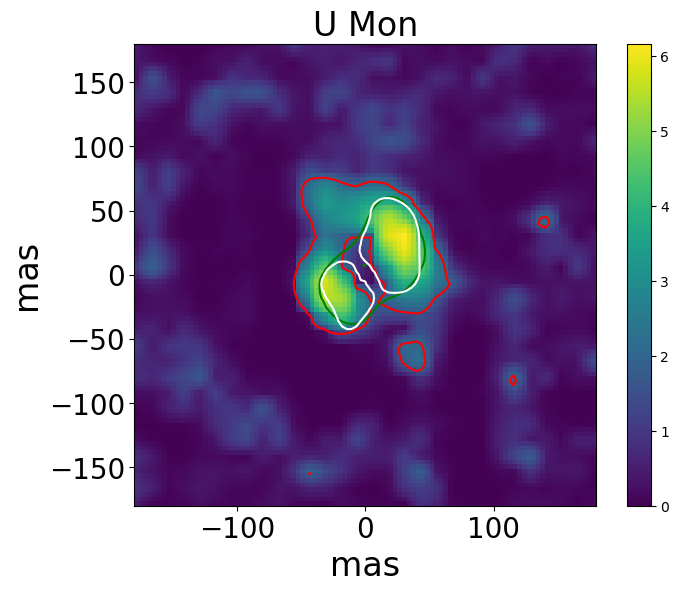

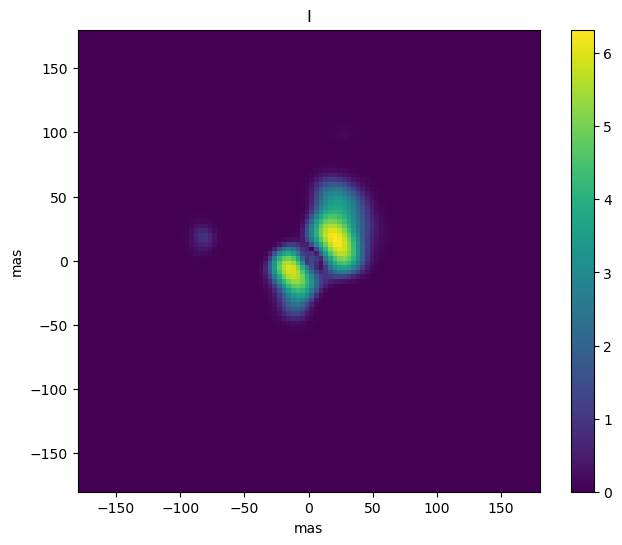

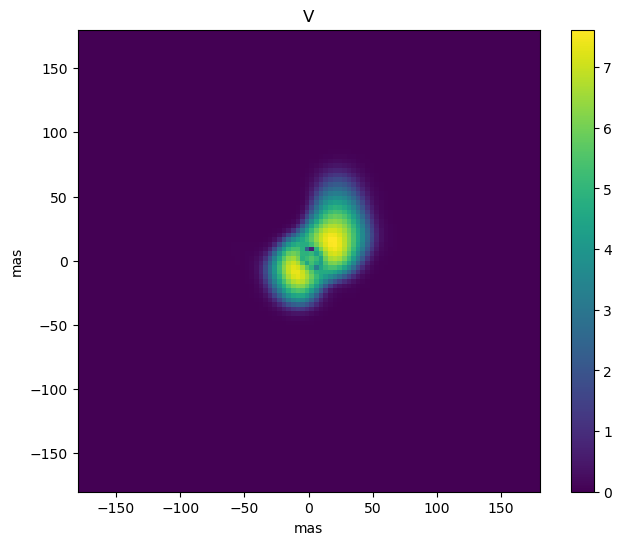

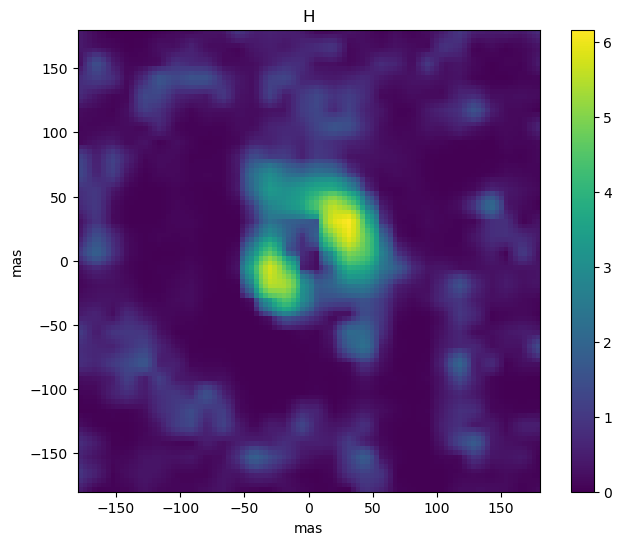

In [78]:
if zimp_to_irdis[star]!='none':
    q_phi_H_resc=rescale(q_phi_H, 12.27/ps,anti_aliasing=True)
    pi_H_resc=rescale(pi_H, 12.27/ps,anti_aliasing=True)

    adc=int(q_phi_H_resc.shape[0]/2-q_phi_I.shape[0]/2)
    bdc=int(q_phi_H_resc.shape[0]/2+q_phi_I.shape[0]/2)
    q_phi_H_resc=q_phi_H_resc[adc:bdc,adc:bdc]
    pi_H_resc=pi_H_resc[adc:bdc,adc:bdc]

    i_H=rescale(i_H, 12.27/ps,anti_aliasing=True)
    adc=int(i_H.shape[0]/2-512)
    bdc=int(i_H.shape[0]/2+512)
    i_H=i_H[adc:bdc,adc:bdc]

n=i_V.shape[0]
 #Creating grid         
xr = np.linspace(-n/2, n/2, num=n)
yr = np.linspace(-n/2, n/2, num=n)
x0 = 0.5
y0 = 0.5
xr = xr-x0
yr = yr-y0
X, Y = np.meshgrid(xr, yr)
R = np.sqrt(X**2 + Y**2)

mask=(R<=1500/ps)
print(i_I.shape[0])
print(R.shape[0])

i_sum_I=np.sum(i_I[mask])
i_sum_V=np.sum(i_V[mask])
if zimp_to_irdis[star]!='none':
    i_sum_H=np.sum(i_H[mask])


for_color=2#/np.max(np.arcsinh(pi_I))




image=np.arcsinh(pi_H_resc)
fig, ax = plt.subplots(1,1,figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
d = (n-1) * ps / 2
extent=(-d, d, d, -d)
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)

if zimp_to_irdis[star]!='none':
    levels = [3]  # Adjust this as needed
    CS = ax.contour(X*ps, Y*ps, pi_H_resc, levels=levels, colors=['red'], extent=extent) 
levels = [3]
CS = ax.contour(X*ps, Y*ps, pi_V, levels=levels, colors=['green'], extent=extent)
levels = [2]  # Adjust this as needed
CS = ax.contour(X*ps, Y*ps, pi_I, levels=levels, colors=['white'], extent=extent)

plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas', fontsize=24)
plt.ylabel('mas', fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20) 
plt.title(starnames[star], fontsize=24) 

plt.colorbar()
plt.tight_layout      

f.scale_mas(star,ax)  

#plt.title('All PI') 
plt.savefig(savefig_folder+star+'_all_pi_0.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


image=np.arcsinh(pi_I)
fig, ax = plt.subplots(figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
d = (n-1) * ps / 2
extent=(-d, d, d, -d)
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
plt.colorbar()
plt.tight_layout      
f.scale_mas(star,ax)  
plt.title('I') 
plt.savefig(savefig_folder+star+'_pi_I.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

image=np.arcsinh(pi_V)
fig, ax = plt.subplots(figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
d = (n-1) * ps / 2
extent=(-d, d, d, -d)
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
plt.colorbar()
plt.tight_layout      
f.scale_mas(star,ax)  
plt.title('V') 
plt.savefig(savefig_folder+star+'_pi_V.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

if zimp_to_irdis[star]!='none':

    image=np.arcsinh(pi_H_resc)
    fig, ax = plt.subplots(figsize=(8,6))
    n=image.shape[0]
    max = np.max(image*(R<200))
    min=np.min(image*(R<200))
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)
    plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    # plt.clim(0,6)
    plt.tight_layout      
    f.scale_mas(star,ax)  
    plt.title('H') 
    plt.savefig(savefig_folder+star+'_pi_H.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()




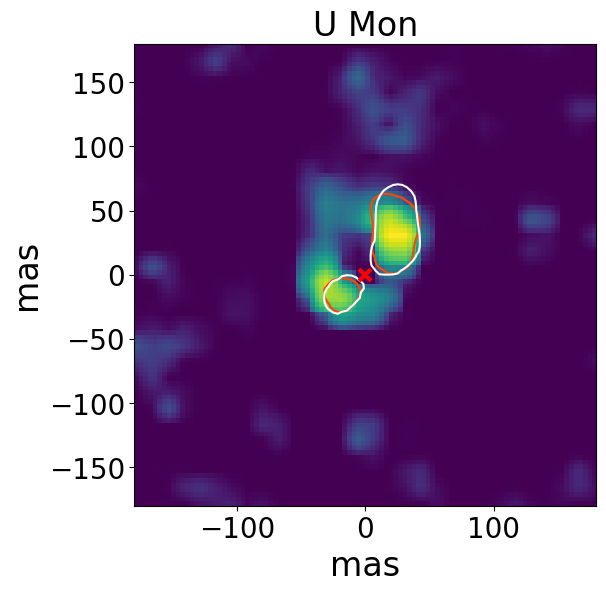

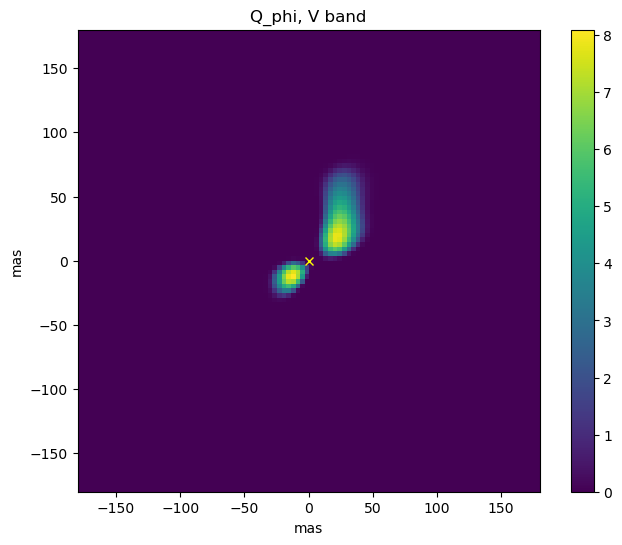

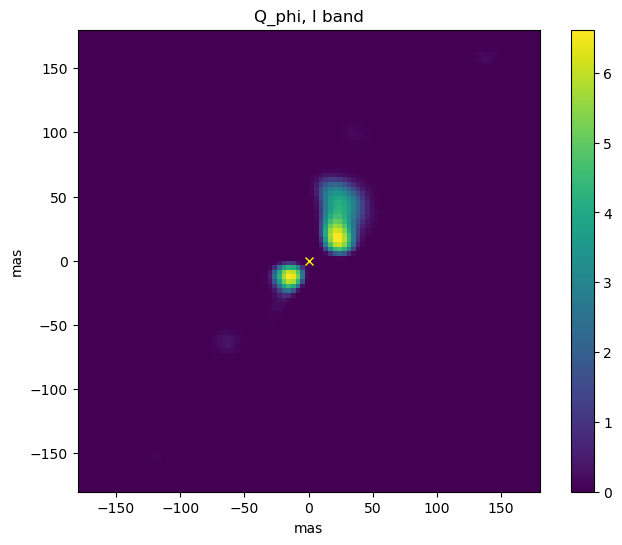

In [32]:
if zimp_to_irdis[star]!='none':

    image=np.arcsinh(q_phi_H_resc)
else:
    image=np.arcsinh(q_phi_I)
fig, ax = plt.subplots(1,1,figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
d = (n-1) * ps / 2
extent=(-d, d, d, -d)
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)


levels = [1]  # Adjust this as needed
if zimp_to_irdis[star]!='none':
    CS = ax.contour(X*ps, Y*ps, q_phi_I, levels=levels, colors=['orangered'], extent=extent)



levels = [1]  # Adjust this as needed
CS = ax.contour(X*ps, Y*ps, q_phi_V, levels=levels, colors=['white'], extent=extent)
plt.plot(0,0,'x', color='red', markersize=8, mew=3)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
#plt.colorbar()
plt.tight_layout      

f.scale_mas(star,ax)  
plt.xlabel('mas', fontsize=24)
plt.ylabel('mas', fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20) 
plt.title(starnames[star], fontsize=24) 
plt.savefig(savefig_folder+star+'_all_q_phi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


image=np.arcsinh(q_phi_V)
fig, ax = plt.subplots(figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)
plt.plot(0,0,'x', color='yellow')
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
plt.colorbar()
plt.tight_layout      
f.scale_mas(star,ax)  
plt.title('Q_phi, V band') 
plt.savefig(savefig_folder+star+'_V_q_phi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

image=np.arcsinh(q_phi_I)
fig, ax = plt.subplots(figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<200))
min=np.min(image*(R<200))
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)
plt.plot(0,0,'x', color='yellow')
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
plt.colorbar()
plt.tight_layout      

f.scale_mas(star,ax)  

plt.title('Q_phi, I band') 
plt.savefig(savefig_folder+star+'_I_q_phi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()



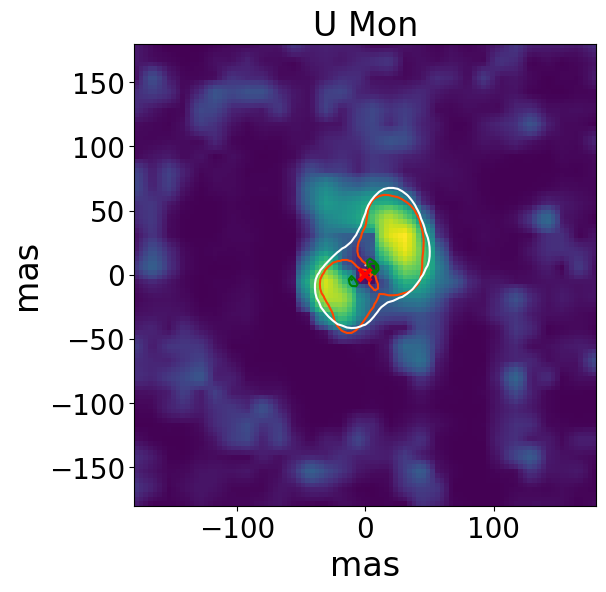

In [55]:
if zimp_to_irdis[star]!='none':

    image=np.arcsinh(pi_H_resc)
else:
    image=np.arcsinh(pi_I)

fig, ax = plt.subplots(1, 1,figsize=(8,6))
n=image.shape[0]
max = np.max(image*(R<100))
min=np.min(image*(R<100))
d = (n-1) * ps / 2
extent=(-d, d, d, -d)
plt.imshow(image,cmap='viridis',vmax=max,vmin=min, extent=extent)

if star=='HR4226':
    
    levels = [5]  # Adjust this as needed
else:
    levels = [1.1]
if zimp_to_irdis[star]!='none':
    CS = ax.contour(X*ps, Y*ps, pi_I, levels=levels, colors=['orangered'], extent=extent)



levels = [1]  # Adjust this as needed
CS = ax.contour(X*ps, Y*ps, pi_V, levels=levels, colors=['white'], extent=extent)

CS = ax.contour(X*ps, Y*ps, pi_H, levels=30, colors=['green'], extent=extent)

plt.plot(0,0,'x', color='red', markersize=8, mew=3)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas', fontsize=24)
plt.ylabel('mas', fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20) 
plt.title(starnames[star], fontsize=24) 

f.scale_mas(star,ax)  
#plt.colorbar()

plt.savefig(savefig_folder+star+'_all_pi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

